In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# define pdfs
def w1(z):
    return tf.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tf.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tf.exp(-(z[0]-1.)/.3))**-1
def pot0(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0)-0.)/.4)**2 - tf.log(tf.exp(-.5*((z[0]-0.)/.8)**2) )
def pot1(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0)-2.)/.4)**2 - tf.log(tf.exp(-.5*((z[0]-2.)/.6)**2) + tf.exp(-.5*((z[0]+2.)/.6)**2))
def pot2(z):
    z = tf.transpose(z)
    return .5*((z[1]-w1(z))/.4)**2
def pot3(z):
    z = tf.transpose(z)
    return -tf.log(tf.exp(-.5*((z[1]-w1(z))/.35)**2) + tf.exp(-.5*((z[1]-w1(z)+w2(z))/.35)**2))
def pot4(z):
    z = tf.transpose(z)
    return -tf.log(tf.exp(-.5*((z[1]-w1(z))/.4)**2) + tf.exp(-.5*((z[1]-w1(z)+w3(z))/.35)**2))
def pot5(z):
    z = tf.transpose(z)
    #return -tf.log(tf.exp(-.5*((z[0]**2+z[1]**2)-4)**2))
    return .5*((z[0]**2+z[1]**2)-4)**2
def pot6(z):
    z = tf.transpose(z)
    return -tf.log(tf.exp(-.5*(((z[0]-1.5)/.8)**2+((z[1]-1.5)/.8)**2))+tf.exp(-.5*(((z[0]+1.5)/.2)**2+((z[1]+1.5)/.2)**2)))

In [3]:
def evaluate_bivariate(rng, npoints):
    """Evaluate (possibly unnormalized) pdf over a meshgrid."""
    side = np.linspace(rng[0], rng[1], npoints)
    z1, z2 = np.meshgrid(side, side)
    zv = np.hstack([z1.reshape(-1, 1), z2.reshape(-1, 1)])
    return z1, z2, zv
def plot_pdf(pdf,rng=[-4,4],npts=50):
    z_pp  = tf.placeholder(tf.float32, [None, 2])
    prob = tf.exp(-pdf(z_pp))
    mesh_z1, mesh_z2, zv = evaluate_bivariate(rng=rng, npoints=npts)
    with tf.Session() as s:
        phat_z = s.run(prob, feed_dict={z_pp: zv} ) 
    phat_z=phat_z.reshape([npts,npts])
    fig,ax = plt.subplots(figsize=(5,5))
    ax.pcolormesh(mesh_z1, mesh_z2, phat_z)
    z_min, z_max = -np.abs(phat_z).max(), np.abs(phat_z).max()
    plt.pcolor(mesh_z1, mesh_z2, phat_z, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.xlim(rng); plt.ylim(rng); ax.set_title('Target distribution: $u(z)$')
    plt.show()

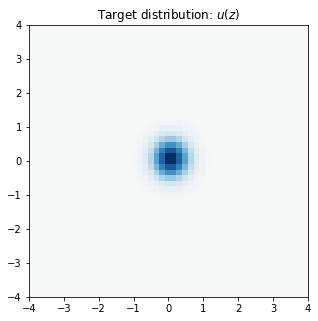

In [11]:
# view target distribution
plot_pdf(pot0)

In [19]:
def ref_samples(mean,std,nsamples):
    # samples from multivariate gaussian with diagonal covariance
    assert len(mean)==len(std)
    return tf.stack([tf.random.normal([nsamples],mean=m,stddev=s) for m,s in zip(mean,std)],axis=1)
def nlog_ref_pdf(x,mean,std):
    # evaluate reference pdf (multivariate gaussian with diag cov) at each x
    # x has size (n_samples,dim_x)
    # mean and std have size (dim_x)
    assert len(mean)==len(std)
    C = np.sqrt(np.prod(2*np.pi*np.array(std)**2))
    mean = tf.constant(mean,dtype=tf.float32)[tf.newaxis,:]
    std = (tf.constant(std,dtype=tf.float32))[tf.newaxis,:]
    xm = (x-mean)/std
    return .5*tf.reduce_sum(xm**2,axis=1)+np.log(C)

In [25]:
mean = [0,0]
std = [3,3]
r_samp = ref_samples(mean,std,1000)
r_pdf = nlog_ref_pdf(r_samp,mean,std)
with tf.Session() as s:
    r_samp_, r_pdf_ = s.run([r_samp,r_pdf])

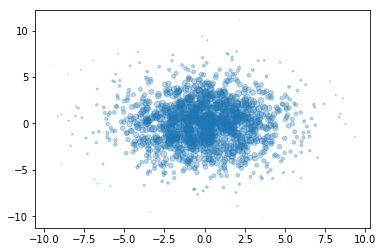

In [26]:
# make sure samples and pdf are working
plt.scatter(r_samp_[:,0],r_samp_[:,1],s=np.exp(-1*r_pdf_)*5000,alpha=.3)
plt.show()

In [ ]:
# define discriminator

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

In [ ]:
# define params

dim = 2
r_mean = np.array([0,0])
r_std = np.array([3,3])

In [ ]:
# define discriminator



In [ ]:
# noise samples and transformed noise samples
eps = tf.random.normal((n_samples,2))
mu = tf.Variable([1,-1]) # this variable will be learned
std = tf.Variable([1,3]) # this variable will also be learned
f_eps = (eps-mu[tf.newaxis,:])*std[tf.newaxis,:]

# reference samples
r_samp = (tf.random.normal((n_samples,2))-r_mean[tf.newaxis,:])*r_std[tf.newaxis,:]

# discriminator loss and training step
dsc_loss = -tf.reduce_sum(tf.log_sigmoid(dsc(f_eps)))-tf.reduce_sum(
    tf.log(1-tf.sigmoid(dsc(r_samp))))
dsc_train = tf.train.AdamOptimizer().minimize(dsc_loss,var_list=[dsc_vars])

# use this instead:
loss_dual = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=Tjoint, labels=tf.ones_like(Tjoint))
    + tf.nn.sigmoid_cross_entropy_with_logits(logits=Tseperate, labels=tf.zeros_like(Tseperate))
)

# generator loss and training step
u = pot0 # choose target distribution
gen_loss = tf.log(ref_pdf(f_eps)) + u(f_eps) - dsc(f_eps)
gen_train = tf.train_AdamOptimizer().minimize(gen_loss,var_list=[mu,std])

In [ ]:
def learn(n_iter):
    with tf.Session() as s:
        for i in range(n_iter):
        
            # draw from epsilon and reference
        
            # update discriminator parameters
        
            # update generator parameters